# Exploratory Data Analysis and Visualizations

Now since we have completed the pre processing and cleansing of the raw data, let us run some alalytics and visualizations on it. For thie fisrt we will write some handy functions and then visualize the data

### Import necessary libs

In [9]:
import sys
import os
sys.path.insert(0, '../src')

In [10]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
import mediapipe as mp
from torch.utils.data import DataLoader
import random
from config import *

random.seed(SEED)

In [11]:
def calculate_avg_landmark_positions(dataset):
    """
    Calculate the average landmark positions for left-hand, right-hand, and face landmarks for each sign in the dataset.
    The purpose of this function is to compute the average positions of landmarks for left-hand, right-hand, and face for each sign in the training dataset.
    
    Returns:
    List : Containing a dictionary with average x/y positions with keys
    -   'left_hand'
    -   'right_hand'
    -   'face'
        
    :param dataset: The ASL dataset object containing the training data.
    :type dataset: ASLDataset
    
    :return: A list containing a dictionary with average x/y positions with keys 'left_hand', 'right_hand', and 'face' for each sign.
    :rtype: List[Dict[str, np.ndarray]]
    """
    df_train = pd.read_csv(os.path.join(ROOT_PATH, PROCESSED_DATA_DIR, TRAIN_CSV_FILE))
    avg_landmarks_pos = {}

    # Loop over each unique sign in the training dataset
    signs = df_train['sign'].unique()
    for c, sign in tqdm(enumerate(signs), total=len(signs)):
        sign_rows = df_train[df_train['sign'] == sign]
        lh_sum, rh_sum, face_sum = np.zeros(2), np.zeros(2), np.zeros(2)
        lh_count, rh_count, face_count = 0, 0, 0

        # Loop over each row (i.e., frame) for the current sign
        for _, row in sign_rows.iterrows():
            file_path = os.path.join(ROOT_PATH, PROCESSED_DATA_DIR, row['path'])
            data = np.load(file_path)
            landmarks = data

            # Extract left-hand, right-hand, and face landmarks
            lh_landmarks = landmarks[:, USED_FACE_FEATURES:USED_FACE_FEATURES + USED_HAND_FEATURES, :]
            rh_landmarks = landmarks[:, USED_FACE_FEATURES + USED_HAND_FEATURES + USED_POSE_FEATURES:, :]
            face_landmarks = landmarks[:, :USED_FACE_FEATURES, :]

            # Compute the means of the x and y coordinates for left-hand, right-hand, and face landmarks
            lh_mean = np.nanmean(lh_landmarks, axis=(0, 1))
            rh_mean = np.nanmean(rh_landmarks, axis=(0, 1))
            face_mean = np.nanmean(face_landmarks, axis=(0, 1))

            # Add the means to the running totals and increment counts
            lh_sum += lh_mean
            rh_sum += rh_mean
            face_sum += face_mean
            lh_count += 1
            rh_count += 1
            face_count += 1

        # Compute the average positions of landmarks for left-hand, right-hand, and face
        avg_lh_landmarks_pos = lh_sum / lh_count
        avg_rh_landmarks_pos = rh_sum / rh_count
        avg_face_landmarks_pos = face_sum / face_count

        # Store the average positions of landmarks in a dictionary for the current sign
        avg_landmarks_pos[sign] = {'left_hand': avg_lh_landmarks_pos,
                                   'right_hand': avg_rh_landmarks_pos,
                                   'face': avg_face_landmarks_pos}

    return avg_landmarks_pos

### Import dataset

In [12]:
from dataset import ASL_DATASET, label_dict_inference, label_dict

In [13]:
dataset = ASL_DATASET(augment=True)
dataset

ASL_DATASET(Participants: 21, Length: 70434

In [14]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
len(dataloader)

70434

### Method to visualize some class samples

In [15]:
def visualize_target_sign(dataset, target_sign, n_samples=6):
    """
    Visualize `n_samples` instances of a given target sign from the dataset.

    This function generates a visual representation of the landmarks for each sample
    belonging to the specified `target_sign`.

    Args:
        dataset (ASL_Dataset): The ASL dataset to load data from.
        target_sign (int): The target sign to visualize.
        n_samples (int, optional): The number of samples to visualize. Defaults to 6.

    Returns:
        matplotlib.animation.FuncAnimation: A matplotlib animation object displaying the landmarks for each frame.
        
    :param dataset: The ASL dataset to load data from.
    :type dataset: ASL_Dataset
    :param target_sign: The target sign to visualize.
    :type target_sign: int
    :param n_samples: The number of samples to visualize, defaults to 6.
    :type n_samples: int, optional
    
    :return: A matplotlib animation object displaying the landmarks for each frame.
    :rtype: matplotlib.animation.FuncAnimation
    """

    print('Generating ', end='')
    target_indices = []
    for i, sample in enumerate(dataset):
        if sample['target'] == target_sign:
            target_indices.append(i)
            print('.', end='')
            if len(target_indices) >= n_samples:
                break

    # Randomly choose n_samples samples from the target_indices
    selected_indices = random.sample(target_indices, min(n_samples, len(target_indices)))

    # Retrieve the samples from the dataset
    samples = [dataset[i] for i in selected_indices]

    fig, ax = plt.subplots(1, figsize=(8 * len(samples) / 2, 10))

    size = 0
    target = int(samples[0]['target'])

    for i, sample in enumerate(samples):
        if sample['size'] > size:
            size = int(sample['size'])

    offset = 20

    def update(frame):
        ax.cla()
        print('.', end='')

        for sample_idx, sample in enumerate(samples):

            frames = sample['landmarks']
            landmark_lists = frames[:size]

            landmark_offset = 192 * sample_idx

            # `landmark_lists` is a list containing sequence of mediapipe landmarks for face, left_hand, pose, and right_hand
            face_landmarks = landmark_lists[:, FACE_INDICES, :]
            left_hand_landmarks = landmark_lists[:, LEFT_HAND_INDICES, :]
            pose_landmarks = landmark_lists[:, POSE_INDICES, :]
            right_hand_landmarks = landmark_lists[:, RIGHT_HAND_INDICES, :]

            face_connections = mp.solutions.face_mesh_connections.FACEMESH_CONTOURS
            pose_connections = mp.solutions.pose.POSE_CONNECTIONS
            hand_connections = mp.solutions.hands.HAND_CONNECTIONS

            new_face_landmark_map = {x: i for i, x in enumerate(USEFUL_FACE_LANDMARKS)}
            face_connections = frozenset((new_face_landmark_map[x], new_face_landmark_map[y]) for (x, y) in face_connections if x in USEFUL_FACE_LANDMARKS and y in USEFUL_FACE_LANDMARKS)

            pose_first_idx=USEFUL_POSE_LANDMARKS[0]-POSE_FEATURE_START
            new_pose_landmark_map = new_pose_landmark_map = {i+pose_first_idx: x for i, x in enumerate(USEFUL_POSE_LANDMARKS-USEFUL_POSE_LANDMARKS[0])}
            pose_connections = frozenset((new_pose_landmark_map[x], new_pose_landmark_map[y]) for (x, y) in pose_connections if x in new_pose_landmark_map.keys() and y in new_pose_landmark_map.keys())

            face_x = [-float(x) + sample_idx * 2 for x in face_landmarks[frame][:, 0]]
            face_y = [-float(y) for y in face_landmarks[frame][:, 1]]
            pose_x = [-float(x) + sample_idx*2 for x in pose_landmarks[frame][:, 0]]
            pose_y = [-float(y)  for y in pose_landmarks[frame][:, 1]]
            lh_x   = [-float(x) + sample_idx*2 for x in left_hand_landmarks[frame][:, 0]]
            lh_y   = [-float(y)  for y in left_hand_landmarks[frame][:, 1]]
            rh_x   = [-float(x) + sample_idx*2 for x in right_hand_landmarks[frame][:, 0]]
            rh_y   = [-float(y)  for y in right_hand_landmarks[frame][:, 1]]

            ax.scatter(pose_x, pose_y)
            ax.scatter(face_x, face_y,s=5)
       
            for i in pose_connections:
                ax.plot([pose_x[i[0]], pose_x[i[1]]],[pose_y[i[0]], pose_y[i[1]]],color='k', lw=0.8)

            for i in face_connections:
                ax.plot([face_x[i[0]], face_x[i[1]]],[face_y[i[0]], face_y[i[1]]],color='k', lw=0.5)

            if round(float(left_hand_landmarks[frame][0, 0]),2)!=0.00 and round(float(left_hand_landmarks[frame][0, 1]),2)!=0.00:
                plt.scatter(lh_x, lh_y,s=10)
                for i in hand_connections:
                    ax.plot([lh_x[i[0]], lh_x[i[1]]],[lh_y[i[0]], lh_y[i[1]]],color='k', lw=0.5)

            if round(float(right_hand_landmarks[frame][0, 0]),2)!=0.00 and round(float(right_hand_landmarks[frame][0, 1]),2)!=0.00:
                plt.scatter(rh_x, rh_y,s=10)
                for i in hand_connections:
                    ax.plot([rh_x[i[0]], rh_x[i[1]]],[rh_y[i[0]], rh_y[i[1]]],color='k', lw=0.5)
                        
        ax.set_ylim(-1.5,0.0)
        ax.set_xlim(-1.5, (len(samples)-1)*2 + 0.5)
        
        ax.set_title(label_dict_inference[target])

    animation = FuncAnimation(fig, update, frames=size, interval=50)
    print(f'\n Frame : {size}: ', end='')
    
    return animation


Generating .
 Frame : 32: .................................CPU times: total: 9.22 s
Wall time: 9.35 s


.

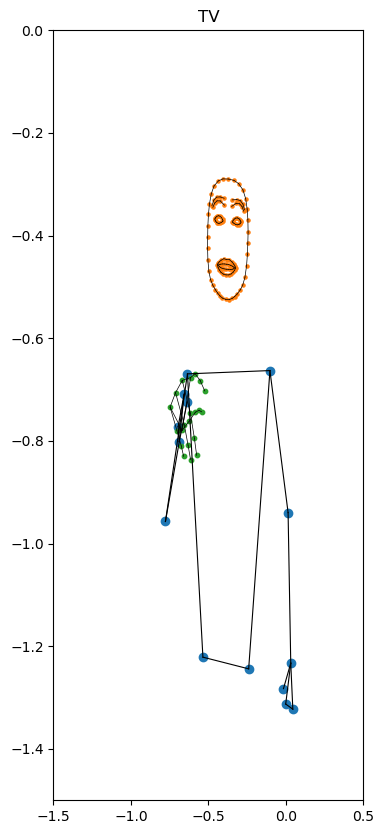

In [8]:
%%time
target_sign = 0
anim = visualize_target_sign(dataset,target_sign,n_samples=1)
HTML(anim.to_jshtml())

### Visualize the distribution of sequence length and number of samples per class

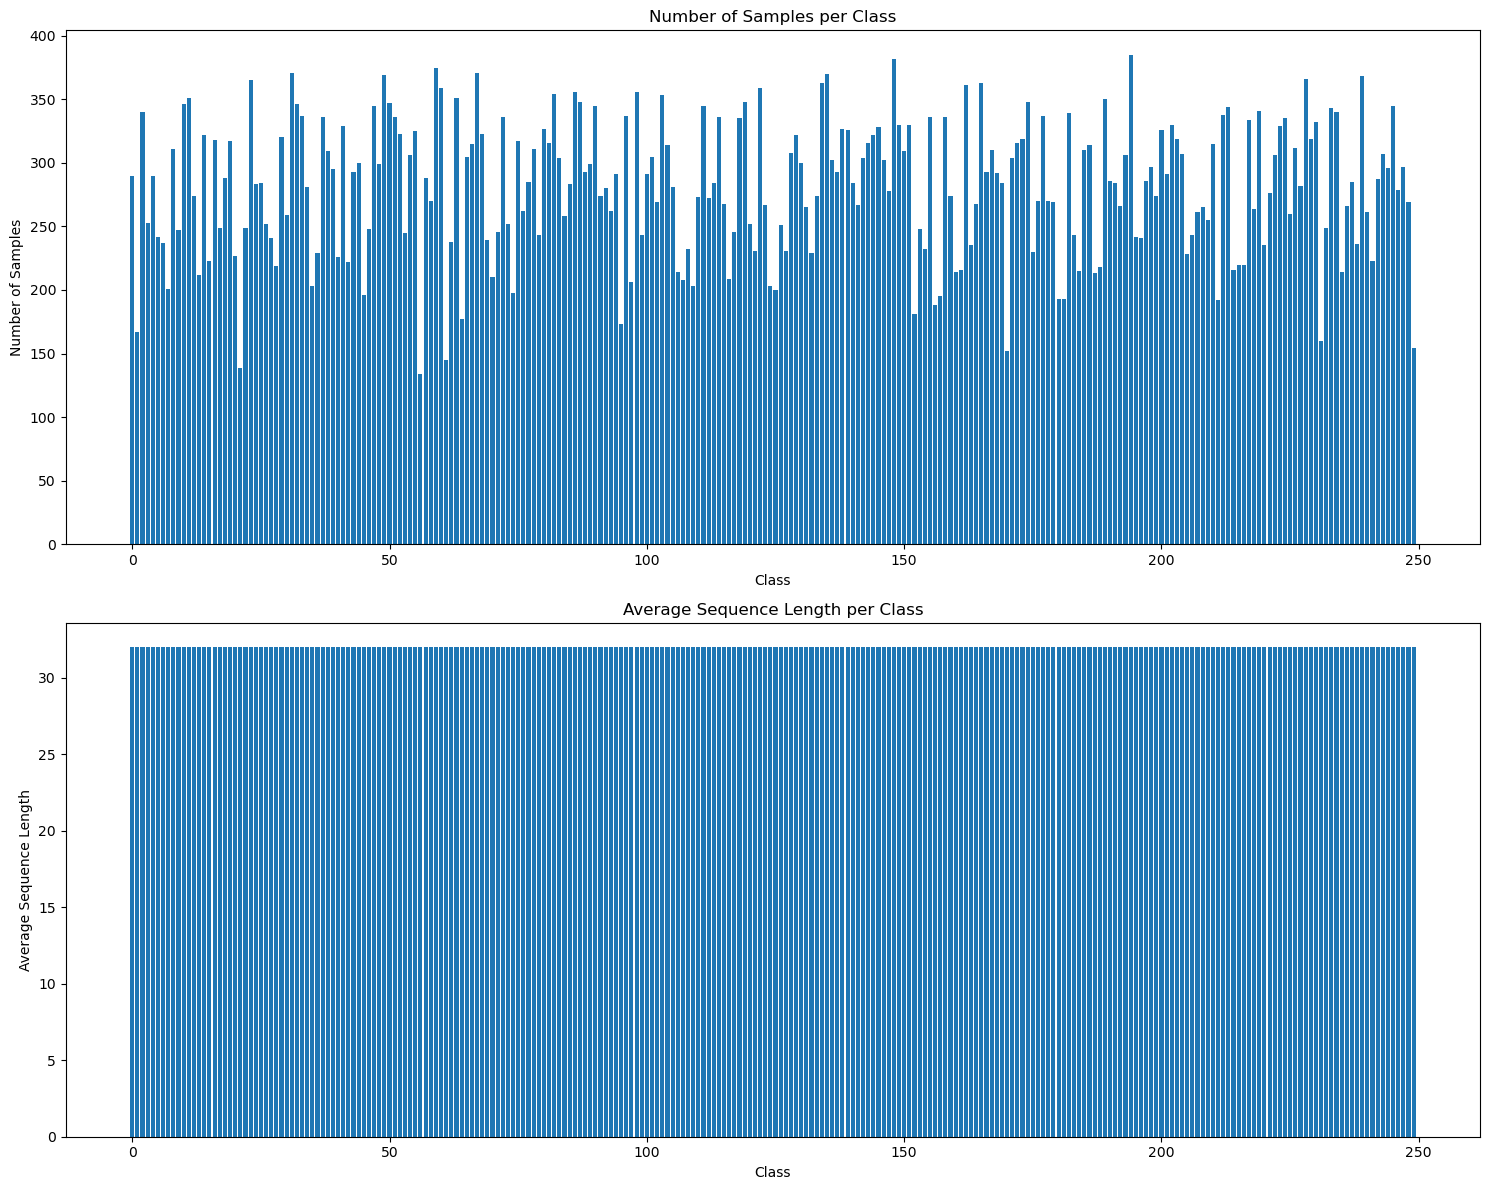

In [16]:
def visualize_data_distribution(dataset):
    """
    Visualize the distribution of data in terms of the number of samples and average sequence length per class.

    This function generates two bar charts: one showing the number of samples per class, and the other showing the
    average sequence length per class.

    :param dataset: The ASL dataset to load data from.
    :type dataset: ASL_Dataset
    """
    
    class_counts = dataset.df_train['target'].value_counts()
    class_lengths = dataset.df_train.groupby('target')['size'].mean()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    ax1.bar(class_counts.index, class_counts.values)
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Samples')
    ax1.set_title('Number of Samples per Class')

    ax2.bar(class_lengths.index, class_lengths.values)
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Average Sequence Length')
    ax2.set_title('Average Sequence Length per Class')

    plt.tight_layout()
    plt.show()


# Visualize the distribution of sequence length and number of samples per class
visualize_data_distribution(dataset)

### Distribution of sequence lengths

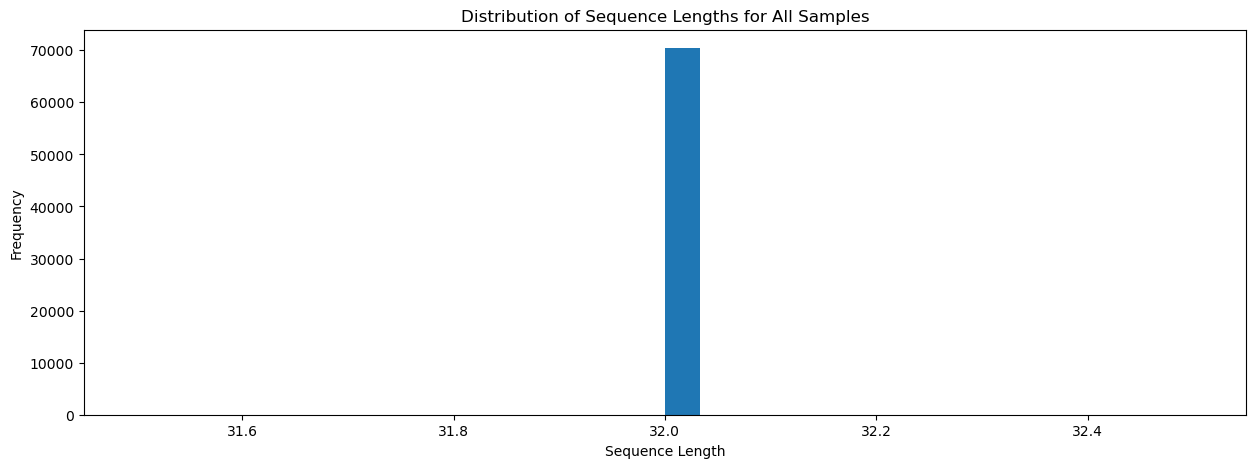

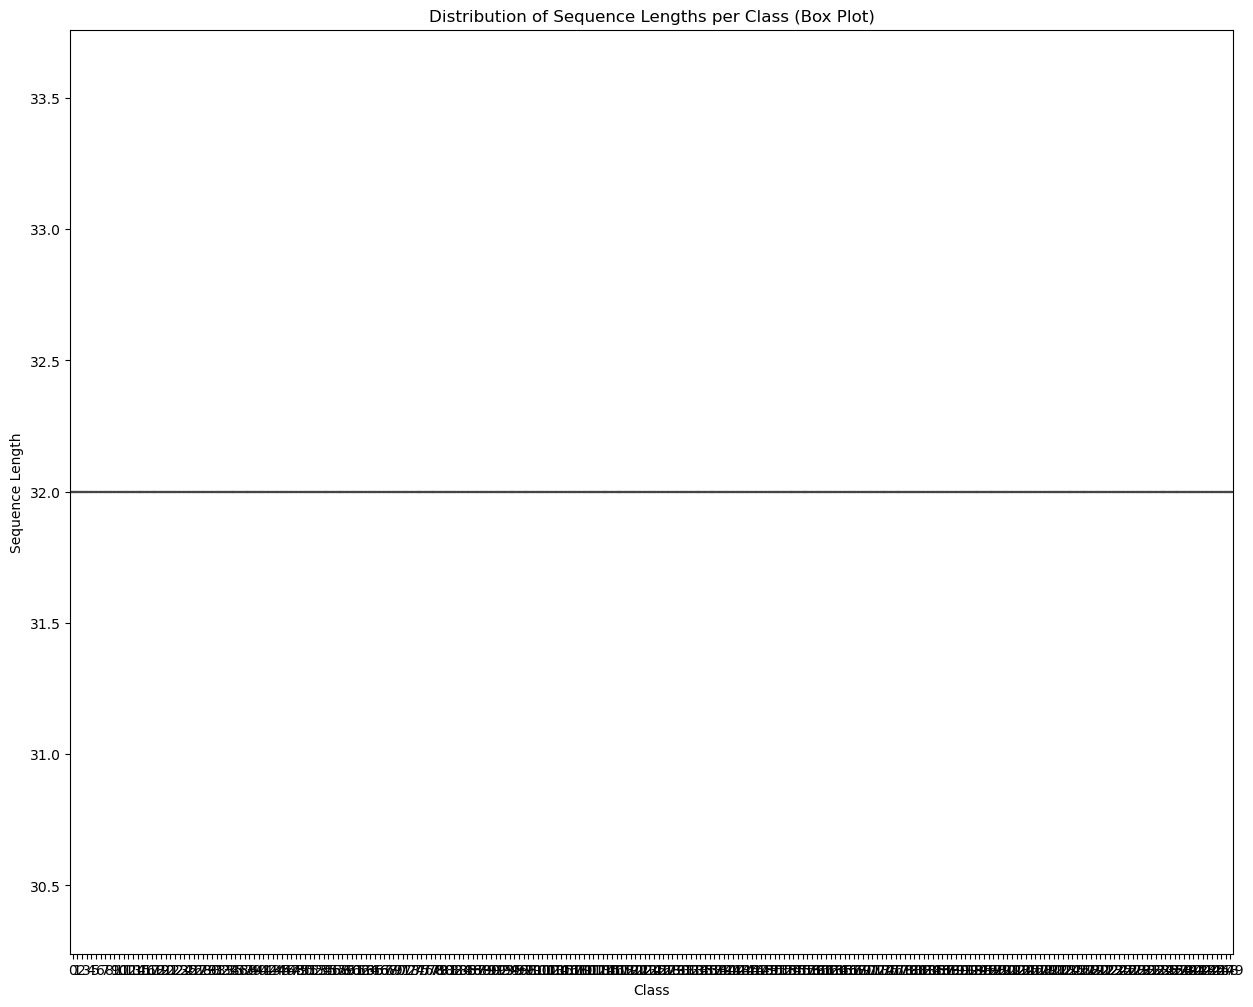

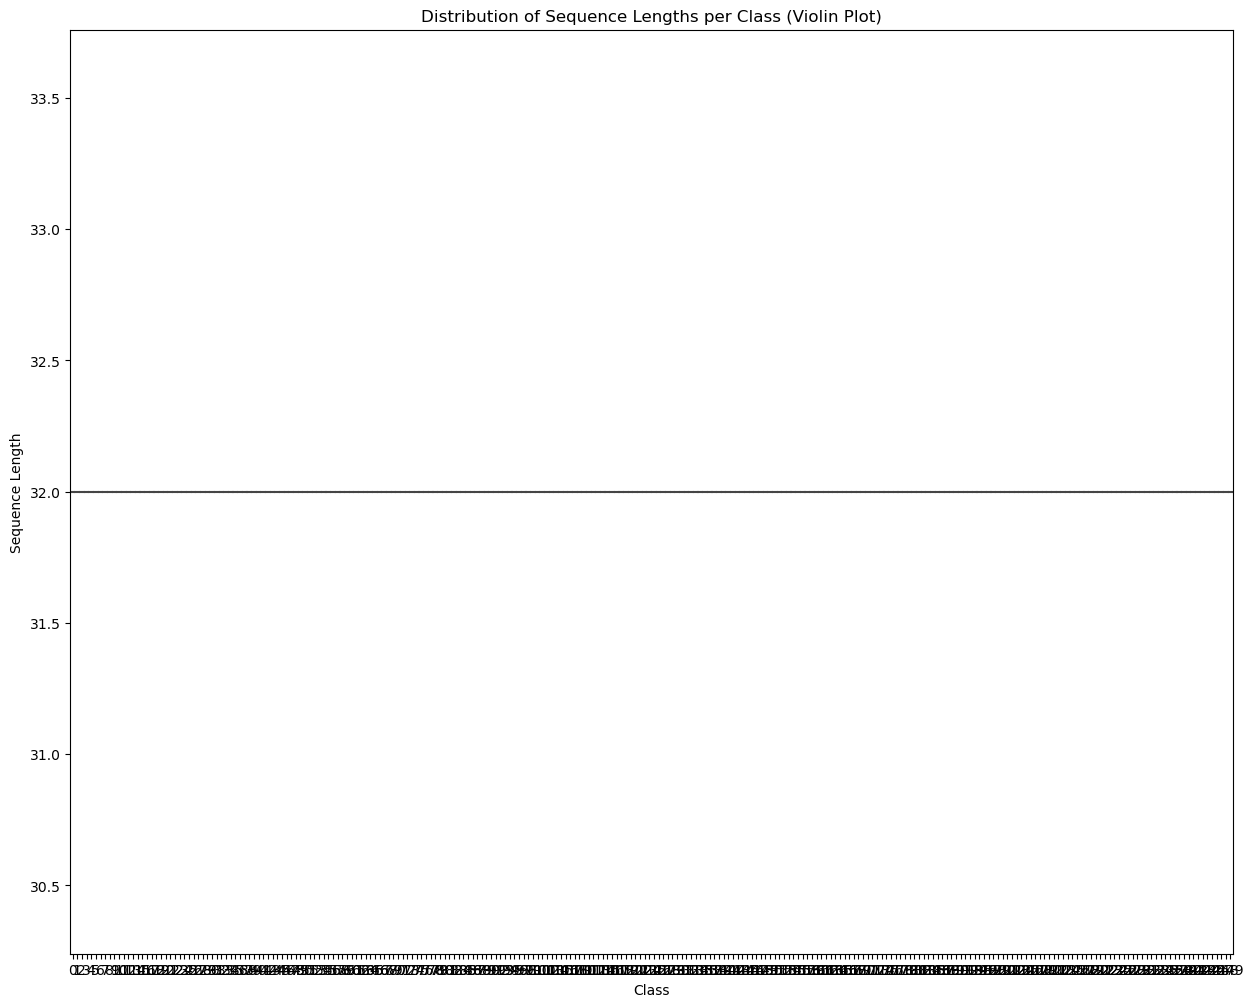

In [17]:
# Calculate the sequence lengths
sequence_lengths = dataset.df_train['size']

# Create a histogram for the distribution of sequence lengths
plt.figure(figsize=(15, 5))
plt.hist(sequence_lengths, bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths for All Samples')
plt.show()

# Create a box plot for the distribution of sequence lengths per class
plt.figure(figsize=(15, 12))
sns.boxplot(x='target', y='size', data=dataset.df_train)
plt.xlabel('Class')
plt.ylabel('Sequence Length')
plt.title('Distribution of Sequence Lengths per Class (Box Plot)')
plt.show()

# Create a violin plot for the distribution of sequence lengths per class
plt.figure(figsize=(15, 12))
sns.violinplot(x='target', y='size', data=dataset.df_train)
plt.xlabel('Class')
plt.ylabel('Sequence Length')
plt.title('Distribution of Sequence Lengths per Class (Violin Plot)')
plt.show()

### Heatmap of the average landmarks

In [13]:
%%time
# Calculate the average landmark positions for each class
avg_landmarks_positions = calculate_avg_landmark_positions(dataset)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [12:13<00:00,  2.93s/it]

CPU times: total: 1min 32s
Wall time: 12min 13s


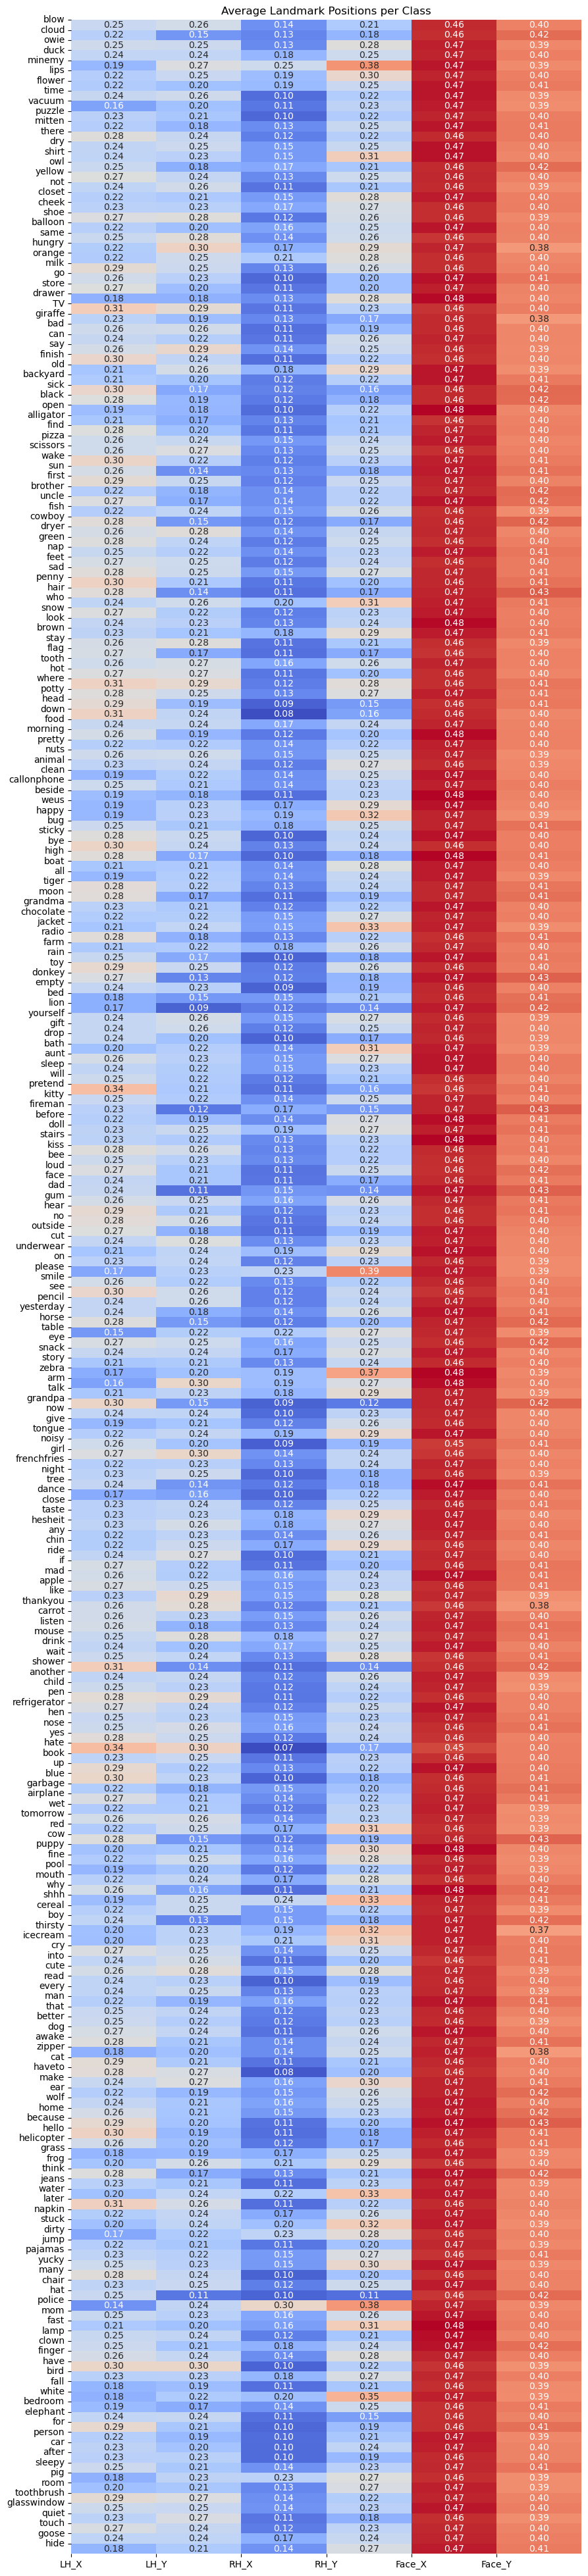

In [48]:
# Prepare the data for heatmap
heatmap_data = []

for sign, positions in avg_landmarks_positions.items():
    row = [
        sign,
        positions['left_hand'][0], positions['left_hand'][1],
        positions['right_hand'][0], positions['right_hand'][1],
        positions['face'][0], positions['face'][1]
    ]
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data, columns=['Class', 'LH_X', 'LH_Y', 'RH_X', 'RH_Y', 'Face_X', 'Face_Y'])

# Create a heatmap for the average landmark positions per class
plt.figure(figsize=(10, 50))
sns.heatmap(heatmap_df.iloc[:, 1:], annot=True, fmt='.2f', cmap='coolwarm', cbar=False)
plt.xticks(ticks=range(6), labels=['LH_X', 'LH_Y', 'RH_X', 'RH_Y', 'Face_X', 'Face_Y'])
plt.yticks(ticks=range(len(heatmap_df)), labels=heatmap_df['Class'], rotation=0)
plt.title('Average Landmark Positions per Class')
plt.show()

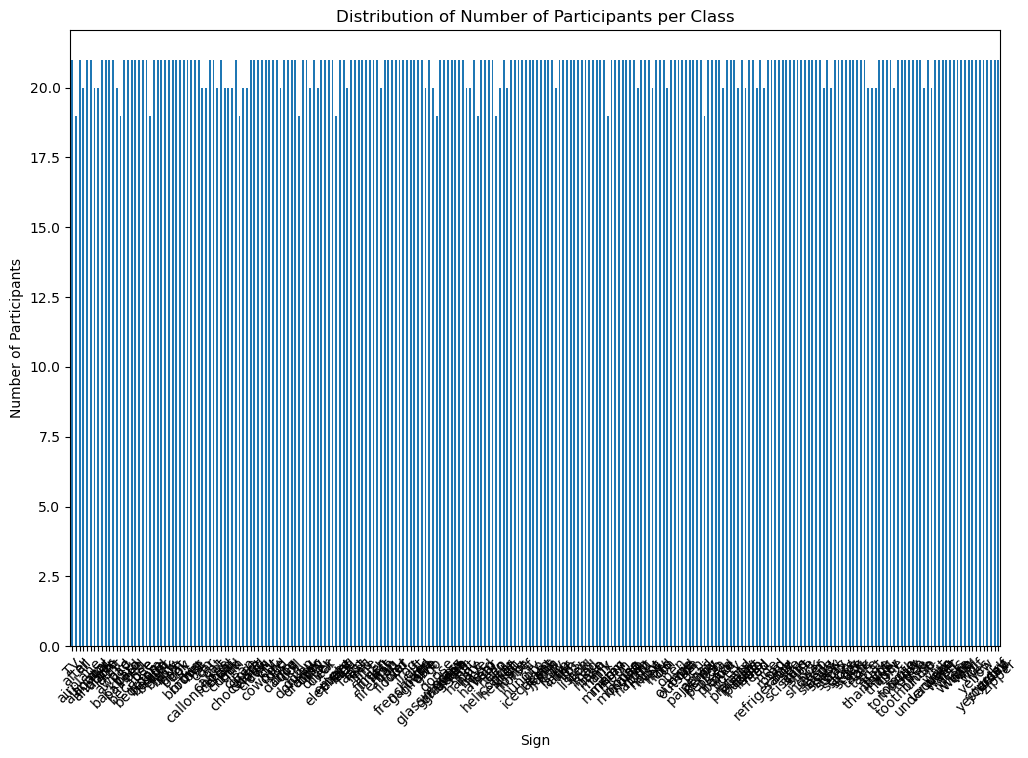

In [18]:
df_train = dataset.df_train

# Calculate the number of participants per class
participants_per_class = df_train.groupby('sign')['participant_id'].nunique()

# Create a bar plot for the number of participants per class
fig, ax = plt.subplots(figsize=(12, 8))
participants_per_class.plot(kind='bar', ax=ax)
plt.xlabel('Sign')
plt.ylabel('Number of Participants')
plt.title('Distribution of Number of Participants per Class')
plt.xticks(rotation=45)
plt.show()

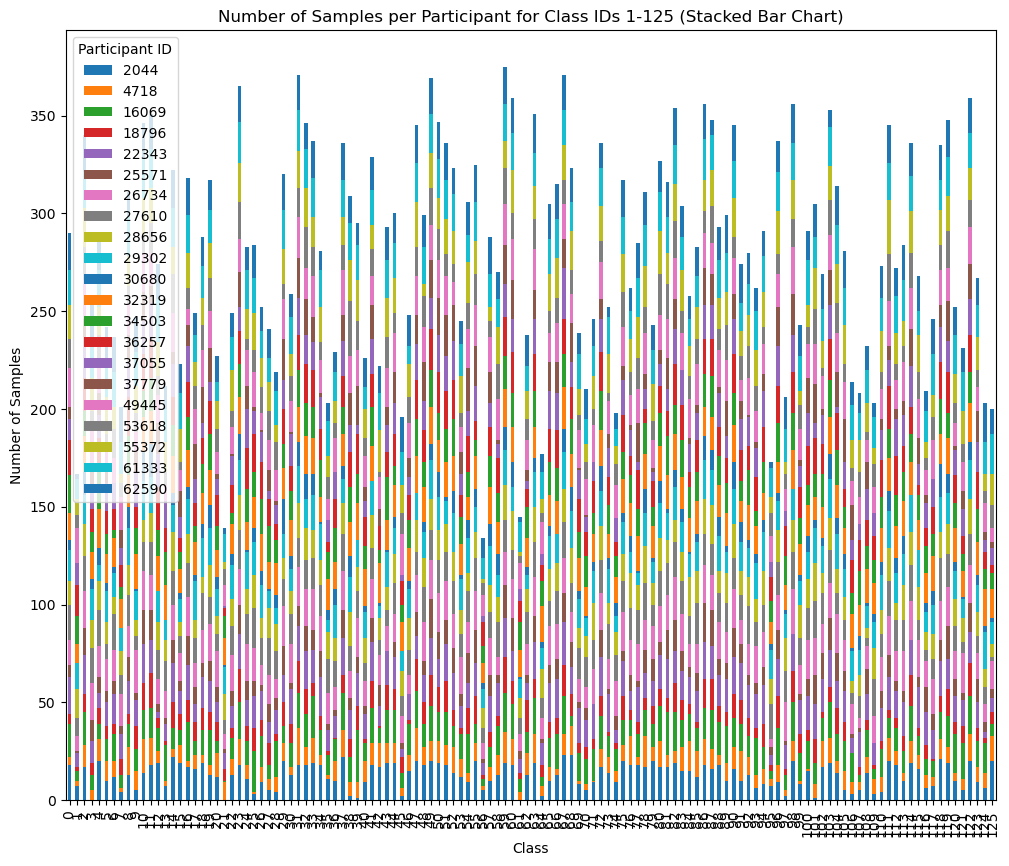

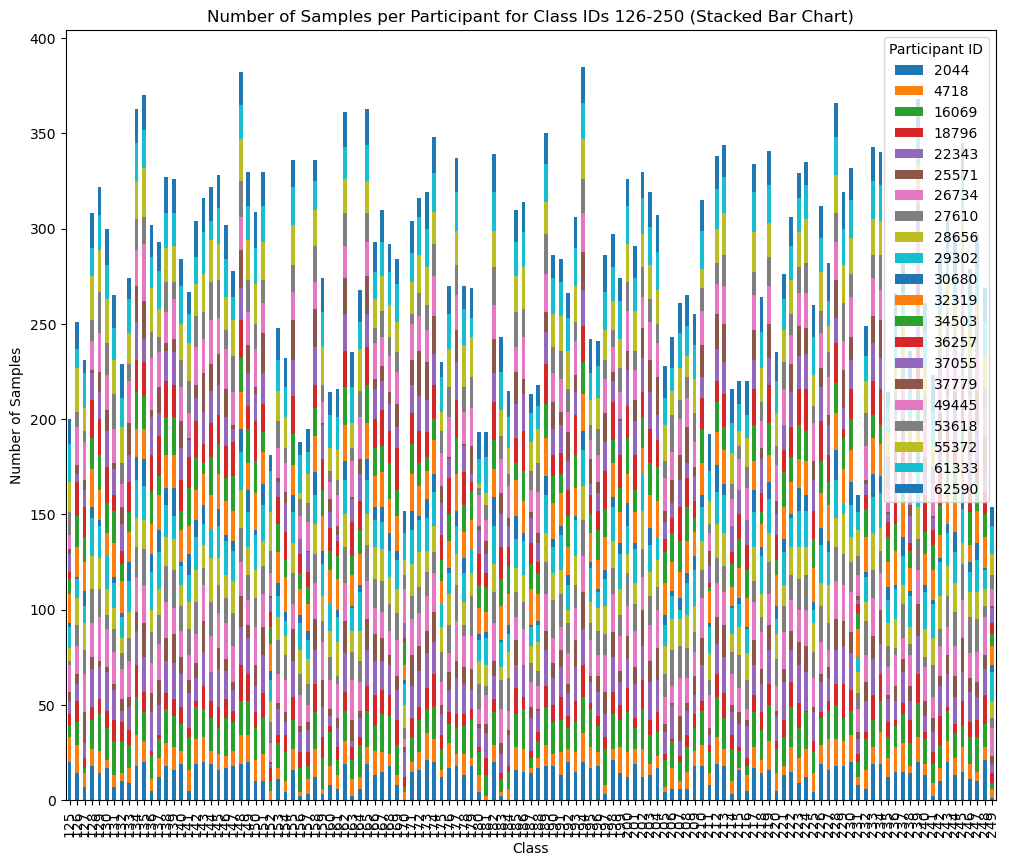

In [19]:
# Prepare the data for bar plots
df_train = dataset.df_train.copy()
class_samples = df_train.groupby(['participant_id', 'target']).size().reset_index(name='num_samples')

# Pivot the data to create a stacked bar chart-ready format
stacked_data = class_samples.pivot_table(index='target', columns='participant_id', values='num_samples', fill_value=0)

# Filter the data for the first chart (class IDs 1-125)
first_chart_data = stacked_data.loc[0:125]

# Create the first stacked bar plot for class IDs 1-125
ax1 = first_chart_data.plot(kind='bar', stacked=True, figsize=(12, 10))
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Participant for Class IDs 1-125 (Stacked Bar Chart)')
plt.legend(title='Participant ID')
plt.show()

# Filter the data for the second chart (class IDs 126-249)
second_chart_data = stacked_data.loc[125:250]

# Create the second stacked bar plot for class IDs 126-250
ax2 = second_chart_data.plot(kind='bar', stacked=True, figsize=(12, 10))
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Participant for Class IDs 126-250 (Stacked Bar Chart)')
plt.legend(title='Participant ID')
plt.show()

In [20]:
# Prepare the data for histogram
landmarks_count = []
for c, i in tqdm(enumerate(range(len(dataset))), total=len(dataset)):
    sample = dataset[i]
    landmarks = sample['landmarks']
    num_landmarks = len(landmarks[0])  # assuming consistent number of landmarks per frame in a sequence
    landmarks_count.append(num_landmarks)

# Create a histogram for the number of landmarks per frame
plt.figure(figsize=(12, 8))
sns.histplot(landmarks_count, bins=20)
plt.xlabel('Number of Landmarks per Frame')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Landmarks per Frame')
plt.show()

 17%|████████████▋                                                              | 11869/70434 [00:16<01:20, 725.63it/s]

